In [11]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from helper import view_classify

In [12]:
# Normalization function for the images from [0, 255] to [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
                              ])

In [13]:
batch_size = 64
# Download the training and testing MNIST dataset
trainset = datasets.MNIST('training-data', download=True, train=True, transform = transform)
valset = datasets.MNIST('training-data', download=True, train=False, transform = transform)

# Partitioning the dataset into batches for training and testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [14]:
# iterator to iterate through our training data set
dataiter = iter(trainloader)
images, labels = dataiter.next()

torch.Size([64, 1, 28, 28])

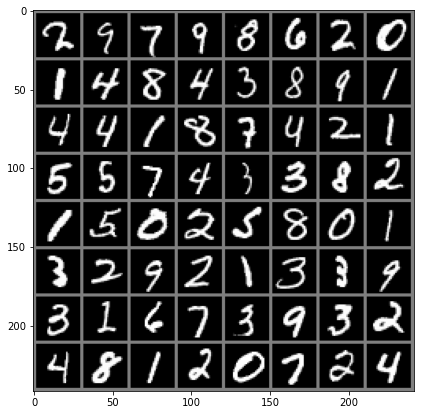

In [15]:
# Simple grid to have a glance at the training dataset
plt.figure(figsize=(7,7))
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [43]:
# model
import torch.nn.functional as F

model = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
    
            # Flatten the input to feed into the dense layers
            nn.Flatten(),

            # Dense layers
            nn.Linear(in_features=32*7*7, out_features=200, bias=False),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=200, out_features=10, bias=False),
            nn.LogSoftmax(dim=1))

In [44]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# cross-entropy loss for the model train (using negative log-likelihood loss)
criterion = nn.NLLLoss()
# variable for training report
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(4)]

# Training the model
def train(epoch):
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))

for epoch in range(3):
    train(epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.442210
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.074675
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.072537
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.093016
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.223738
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.126652
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.103853
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.022998
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.118336
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.016263
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.036288
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.078149
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.005667
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.035475
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.016810
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.093160
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.079296
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.004176
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.013239
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.057600
Train Epoch:

predicted digit =  9


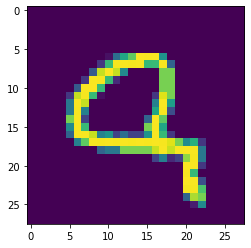

In [46]:
# An image prediction, output a class probability
images , labels = next(iter(valloader))
with torch.no_grad():
    logps = model(images)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("predicted digit = ", probab.index(max(probab)))
plt.imshow(images[0][0])
#view_classify(img.view(1, 28, 28), ps)

In [47]:
# Checking model performance with the testing dataset
def test():
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valloader:
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss += F.nll_loss(output, target, reduction='sum').item()
    test_loss /= len(valloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valloader.dataset),
        100. * correct / len(valloader.dataset)))
test()


Test set: Avg. loss: 0.0491, Accuracy: 9853/10000 (99%)



In [49]:
# Saving model
torch.save(model, './models/conv2d_model.pt')

In [37]:
for i, (d, t) in enumerate(trainloader):
    print(i, d.shape)

0 torch.Size([64, 1, 28, 28])
1 torch.Size([64, 1, 28, 28])
2 torch.Size([64, 1, 28, 28])
3 torch.Size([64, 1, 28, 28])
4 torch.Size([64, 1, 28, 28])
5 torch.Size([64, 1, 28, 28])
6 torch.Size([64, 1, 28, 28])
7 torch.Size([64, 1, 28, 28])
8 torch.Size([64, 1, 28, 28])
9 torch.Size([64, 1, 28, 28])
10 torch.Size([64, 1, 28, 28])
11 torch.Size([64, 1, 28, 28])
12 torch.Size([64, 1, 28, 28])
13 torch.Size([64, 1, 28, 28])
14 torch.Size([64, 1, 28, 28])
15 torch.Size([64, 1, 28, 28])
16 torch.Size([64, 1, 28, 28])
17 torch.Size([64, 1, 28, 28])
18 torch.Size([64, 1, 28, 28])
19 torch.Size([64, 1, 28, 28])
20 torch.Size([64, 1, 28, 28])
21 torch.Size([64, 1, 28, 28])
22 torch.Size([64, 1, 28, 28])
23 torch.Size([64, 1, 28, 28])
24 torch.Size([64, 1, 28, 28])
25 torch.Size([64, 1, 28, 28])
26 torch.Size([64, 1, 28, 28])
27 torch.Size([64, 1, 28, 28])
28 torch.Size([64, 1, 28, 28])
29 torch.Size([64, 1, 28, 28])
30 torch.Size([64, 1, 28, 28])
31 torch.Size([64, 1, 28, 28])
32 torch.Size([64,

262 torch.Size([64, 1, 28, 28])
263 torch.Size([64, 1, 28, 28])
264 torch.Size([64, 1, 28, 28])
265 torch.Size([64, 1, 28, 28])
266 torch.Size([64, 1, 28, 28])
267 torch.Size([64, 1, 28, 28])
268 torch.Size([64, 1, 28, 28])
269 torch.Size([64, 1, 28, 28])
270 torch.Size([64, 1, 28, 28])
271 torch.Size([64, 1, 28, 28])
272 torch.Size([64, 1, 28, 28])
273 torch.Size([64, 1, 28, 28])
274 torch.Size([64, 1, 28, 28])
275 torch.Size([64, 1, 28, 28])
276 torch.Size([64, 1, 28, 28])
277 torch.Size([64, 1, 28, 28])
278 torch.Size([64, 1, 28, 28])
279 torch.Size([64, 1, 28, 28])
280 torch.Size([64, 1, 28, 28])
281 torch.Size([64, 1, 28, 28])
282 torch.Size([64, 1, 28, 28])
283 torch.Size([64, 1, 28, 28])
284 torch.Size([64, 1, 28, 28])
285 torch.Size([64, 1, 28, 28])
286 torch.Size([64, 1, 28, 28])
287 torch.Size([64, 1, 28, 28])
288 torch.Size([64, 1, 28, 28])
289 torch.Size([64, 1, 28, 28])
290 torch.Size([64, 1, 28, 28])
291 torch.Size([64, 1, 28, 28])
292 torch.Size([64, 1, 28, 28])
293 torc

536 torch.Size([64, 1, 28, 28])
537 torch.Size([64, 1, 28, 28])
538 torch.Size([64, 1, 28, 28])
539 torch.Size([64, 1, 28, 28])
540 torch.Size([64, 1, 28, 28])
541 torch.Size([64, 1, 28, 28])
542 torch.Size([64, 1, 28, 28])
543 torch.Size([64, 1, 28, 28])
544 torch.Size([64, 1, 28, 28])
545 torch.Size([64, 1, 28, 28])
546 torch.Size([64, 1, 28, 28])
547 torch.Size([64, 1, 28, 28])
548 torch.Size([64, 1, 28, 28])
549 torch.Size([64, 1, 28, 28])
550 torch.Size([64, 1, 28, 28])
551 torch.Size([64, 1, 28, 28])
552 torch.Size([64, 1, 28, 28])
553 torch.Size([64, 1, 28, 28])
554 torch.Size([64, 1, 28, 28])
555 torch.Size([64, 1, 28, 28])
556 torch.Size([64, 1, 28, 28])
557 torch.Size([64, 1, 28, 28])
558 torch.Size([64, 1, 28, 28])
559 torch.Size([64, 1, 28, 28])
560 torch.Size([64, 1, 28, 28])
561 torch.Size([64, 1, 28, 28])
562 torch.Size([64, 1, 28, 28])
563 torch.Size([64, 1, 28, 28])
564 torch.Size([64, 1, 28, 28])
565 torch.Size([64, 1, 28, 28])
566 torch.Size([64, 1, 28, 28])
567 torc

805 torch.Size([64, 1, 28, 28])
806 torch.Size([64, 1, 28, 28])
807 torch.Size([64, 1, 28, 28])
808 torch.Size([64, 1, 28, 28])
809 torch.Size([64, 1, 28, 28])
810 torch.Size([64, 1, 28, 28])
811 torch.Size([64, 1, 28, 28])
812 torch.Size([64, 1, 28, 28])
813 torch.Size([64, 1, 28, 28])
814 torch.Size([64, 1, 28, 28])
815 torch.Size([64, 1, 28, 28])
816 torch.Size([64, 1, 28, 28])
817 torch.Size([64, 1, 28, 28])
818 torch.Size([64, 1, 28, 28])
819 torch.Size([64, 1, 28, 28])
820 torch.Size([64, 1, 28, 28])
821 torch.Size([64, 1, 28, 28])
822 torch.Size([64, 1, 28, 28])
823 torch.Size([64, 1, 28, 28])
824 torch.Size([64, 1, 28, 28])
825 torch.Size([64, 1, 28, 28])
826 torch.Size([64, 1, 28, 28])
827 torch.Size([64, 1, 28, 28])
828 torch.Size([64, 1, 28, 28])
829 torch.Size([64, 1, 28, 28])
830 torch.Size([64, 1, 28, 28])
831 torch.Size([64, 1, 28, 28])
832 torch.Size([64, 1, 28, 28])
833 torch.Size([64, 1, 28, 28])
834 torch.Size([64, 1, 28, 28])
835 torch.Size([64, 1, 28, 28])
836 torc